In [27]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import joblib
import json
from dataclasses import dataclass

In [ ]:
@dataclass(init=True, repr=True, eq=False, order=False, unsafe_hash=False, frozen=False)
class BenchMarkModel:
    """
    A class to benchmark different models on a given dataset.
    Attributes:
    data: pd.DataFrame or str dataframe or path to the dataframe joblib file
    model_type: str
    split_method: str
    Methods:
    data_preprocessing(*args, **kwargs): Preprocess the data based on the model type and split method.
    split_data(*args, **kwargs): Split the data into training and testing sets.
    """
    data: pd.DataFrame | str
    model_type: str
    split_method: str

    '''
    def __init__(self, data, model_type, split_method, *args, **kwargs):
        """Initialize the BenchMarkModel with data, model type, and split method."""
        if not isinstance(data, pd.DataFrame):
            raise ValueError("Data must be a pandas DataFrame.")
        self.data = data
        self.model_type = model_type
        self.split_method = split_method
        self.args = args
        self.kwargs = kwargs'''

    def __post_init__(self):
        """Post-initialization to handle data loading and type checking."""
        print(f"Initial data type: {type(self.data)}")  # Debug line
        if isinstance(self.data, pd.DataFrame):
            print("Data is already a DataFrame")
            self.data = self.data.copy()  # Ensure we work with a copy
        elif isinstance(self.data, str):
            print(f"Loading data from: {self.data}")
            try:
                self.data = joblib.load(self.data)
                print(f"Data loaded successfully, type: {type(self.data)}")
            except Exception as e:
                print(f"Error loading data: {e}")
                raise ValueError(f"Could not load data from {self.data}: {e}")
        else:
            raise ValueError("Data must be a pandas DataFrame or a valid file path.")
    
    def rename_data_columns(self, rename_dict):
        self.data = self.data.rename(columns=rename_dict)
        return self

    def data_preprocessing(self, *args, **kwargs):
        """Preprocess the data based on the model type and split method."""
        if kwargs.get("rename_dict"):
            self.rename_data_columns(kwargs["rename_dict"])

        if ("metabolite_features" not in self.data.columns) or ("protein_features" not in self.data.columns):
            raise ValueError("Data is missing required feature columns or wrong column name.")
        
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            # Implement preprocessing for these models
            pass
            self.X = np.array([np.concatenate([m, p]) for m, p in zip(self.data["metabolite_features"], self.data["protein_features"])])
            self.y = self.data["label"]
        return self
    
    def split_data(self,  *args, **kwargs):
        """Split the data into training and testing sets.
        save_index_path: str, optional relative path to save and load the indices of train, validation, and test sets.
        split_method: str, method to split the data, options are "random", "cold_mols", "cold_proteins", "load_from_file".
        """

        # create indices for train, validation, and test sets
        if self.split_method == "random" or self.split_method == "random_split":
            self.train_index, self.temp_index = train_test_split(np.arange(len(self.data)),test_size=0.3, shuffle=True, random_state=42)
            self.val_index, self.test_index = train_test_split(self.temp_index, test_size=0.5, shuffle=True, random_state=42)

        elif self.split_method == "cold_mols":
            # Implement cold molecules split logic here
            pass
        elif self.split_method == "cold_proteins":
            # Implement cold proteins split logic here
            pass
        elif self.split_method == "load_from_file":
            # Load indices from a file
            if "index_file_path" not in kwargs:
                raise ValueError("index_file_path must be provided for load_from_file split method.")
            with open(kwargs["index_file_path"], "r") as f:
                indices = json.load(f)
                self.train_index = np.array(indices["train_index"])
                self.val_index = np.array(indices["val_index"])
                self.test_index = np.array(indices["test_index"])
                
            if len(self.train_index)+ len(self.val_index) + len(self.test_index) != len(self.data):
                raise ValueError("Indices from file do not match the length of the data.")   
            
        else:
            raise ValueError(f"Unknown split method: {self.split_method}")
        
        
        # assign the indices to the respective sets
        self.train_X = self.X[self.train_index]
        self.train_y = self.y[self.train_index]
        self.val_X = self.X[self.val_index]
        self.val_y = self.y[self.val_index]
        self.test_X = self.X[self.test_index]
        self.test_y = self.y[self.test_index]

        
        # Save the indices if specified in kwargs
        if kwargs.get("save_index_path"):
            with open(kwargs["save_index_path"], "w") as f:
                json.dump({
                    "train_index": self.train_index.tolist(),
                    "val_index": self.val_index.tolist(),
                    "test_index": self.test_index.tolist()
                }, f)
        return self
    
    def model_init(self, *args, **kwargs):
        """Initialize the model based on the model type."""
        
        print(f"Training {self.model_type}(traditional) model...")
        if self.model_type == "CAT":
            import catboost as cat
            self.model = cat.CatBoostRegressor( *args, **kwargs)
        elif self.model_type == "GBM":
            from sklearn.ensemble import GradientBoostingRegressor
            self.model = GradientBoostingRegressor( *args, **kwargs)
        elif self.model_type == "LR":
            from sklearn.linear_model import LinearRegression
            self.model = LinearRegression( *args, **kwargs)
        elif self.model_type == "RF":
            from sklearn.ensemble import RandomForestRegressor
            self.model = RandomForestRegressor(random_state=42)
        elif self.model_type == "SVR":
            from sklearn.svm import SVR
            self.model = SVR( *args, **kwargs)
        elif self.model_type == "XGB":
            import xgboost as xg
            self.model = xg.XGBRegressor( *args, **kwargs)
        return self

        
    def fit(self, *args, **kwargs):
        """Fit the model to the training data."""
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            self.model.fit(self.train_X, self.train_y)
        return self
    
    def predict(self, X):
        """Predict using the fitted model."""
        if self.model_type in ["CAT", "GBM", "LR", "RF", "SVR", "XGB"]:
            return self.model.predict(X)

In [29]:
bench_mark_model = BenchMarkModel(data="./../../A01_dataset/kcat_with_features.joblib",
                                   model_type="LR",
                                   split_method="random",)
bench_mark_model

Initial data type: <class 'str'>
Loading data from: ./../../A01_dataset/kcat_with_features.joblib
Data loaded successfully, type: <class 'pandas.core.frame.DataFrame'>


BenchMarkModel(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

In [30]:
bench_mark_model.data_preprocessing(rename_dict={"log10kcat_max": "label"})

BenchMarkModel(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

In [31]:
bench_mark_model.split_data().model_init().fit()

Training LR(traditional) model...


BenchMarkModel(data=                                                Sequence sequence_source  \
0      MEPGSKSVSRSDWQPEPHQRPITPLEPGPEKTPIAQPESKTLQGSN...           sabio   
1      MLLAQRRLISLGCRSKPIKTIYSSSKVLGLCTSAKMALKFKNAKRI...          brenda   
2      MPIIQMNLLEGRTVEQKRNAVAAITEAVVRTLDVRPDQVRILINEL...          brenda   
3      MKEAGILFEELVSIMEKLRSPEGCEWDRKQTHESLKPYLIEECYEL...          brenda   
4      MGQEKLYIEKELSWLSFNERVLQEAADKSNPLIERMRFLGIYSNNL...           sabio   
...                                                  ...             ...   
23146  MTVFSAIPPISCWFTGRTPASWDKTMDMQTSFLDRLFEEGLLIETG...           sabio   
23147  MYRSGERLLGSHALPAEQRDFLPLETTNNNNNHHQPGAWARRAGSS...          brenda   
23148  MALRACGLIIFRRCLIPKVDNNAIEFLLLQASDGIHHWTPPKGHVE...           sabio   
23149  MTTAPTPSIFEPARLGPLTLRNRIVKAATFEGVMPRGAVSDDLINF...  uniprot_search   
23150  MLKVISSLLFYMTASLMAVASPLAHSGESRGEYPTVSEIPVGEVRL...          brenda   

          uniprot                                             Smile

In [32]:
bench_mark_model.predict(bench_mark_model.X)

array([ 2.256895  , -0.07117653, -0.05376816, ..., -0.27074242,
        0.84503746,  1.2777939 ], dtype=float32)

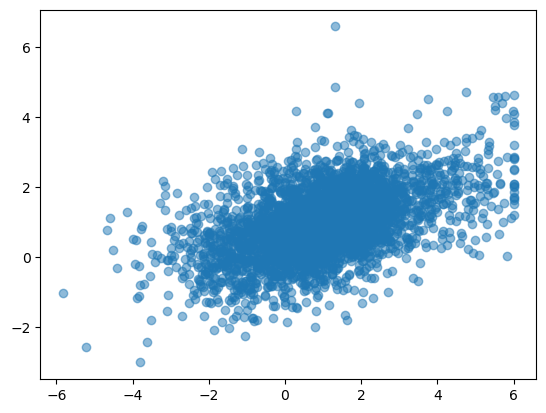

In [34]:
import matplotlib.pyplot as plt
plt.scatter(bench_mark_model.data.loc[bench_mark_model.test_index,"label"], bench_mark_model.predict(bench_mark_model.test_X),alpha=0.5)